# Part 1

From behaviour experiments it appears that each leg is controlled relatively independently. We want to see whether this is supported by the connectome wiring. 

## Part 1A
In order to answer this question we will consider the MDNs as being split in subneurons, each of them restricted to the synapses it makes in a given neuropil. This way, we will have a 'right hind leg MDN set' or a 'left front leg MDN set'. We will then look at the connections from these sets to motor neurons in each leg neuropil. We want to see whether there is cross-talk in the circuits, i.e. whether a MDN set in one leg neuropil connects to motor neurons in another leg neuropil.

## Part 1B
The second part of the question is to understand what kind of movement can be controlled by each MDN set. We want to identify the movement space that can be reached by the front, middle and hind legs upon activation of the MDN sets.

In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries
import copy
import os
import typing
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from MDN_params import MDN_FIGS

from vnc_networks import MANC, CMatrix, Connections, Neuron, params
from vnc_networks.specific_neurons import mdn_helper
from vnc_networks.specific_neurons import motor_neurons_helper as mns_helper
from vnc_networks.utils import matrix_design, plots_design


In [2]:
savefigs = True # True if you want to save the figures

manc_version = "v1.2"

# Part 1A: Independence of leg circuits

### 1Aa Create a connectome with MDNs split by neuropil

In [3]:
CR = MANC(manc_version)
split_mdn_vnc = mdn_helper.get_vnc_split_MDNs_by_neuropil(
        not_connected=mdn_helper.get_mdn_bodyids(),
        CR=CR,
    )  # exclude connections from MDNs to MDNs

Loaded VNC Connections object with MDNs split by neuropil.


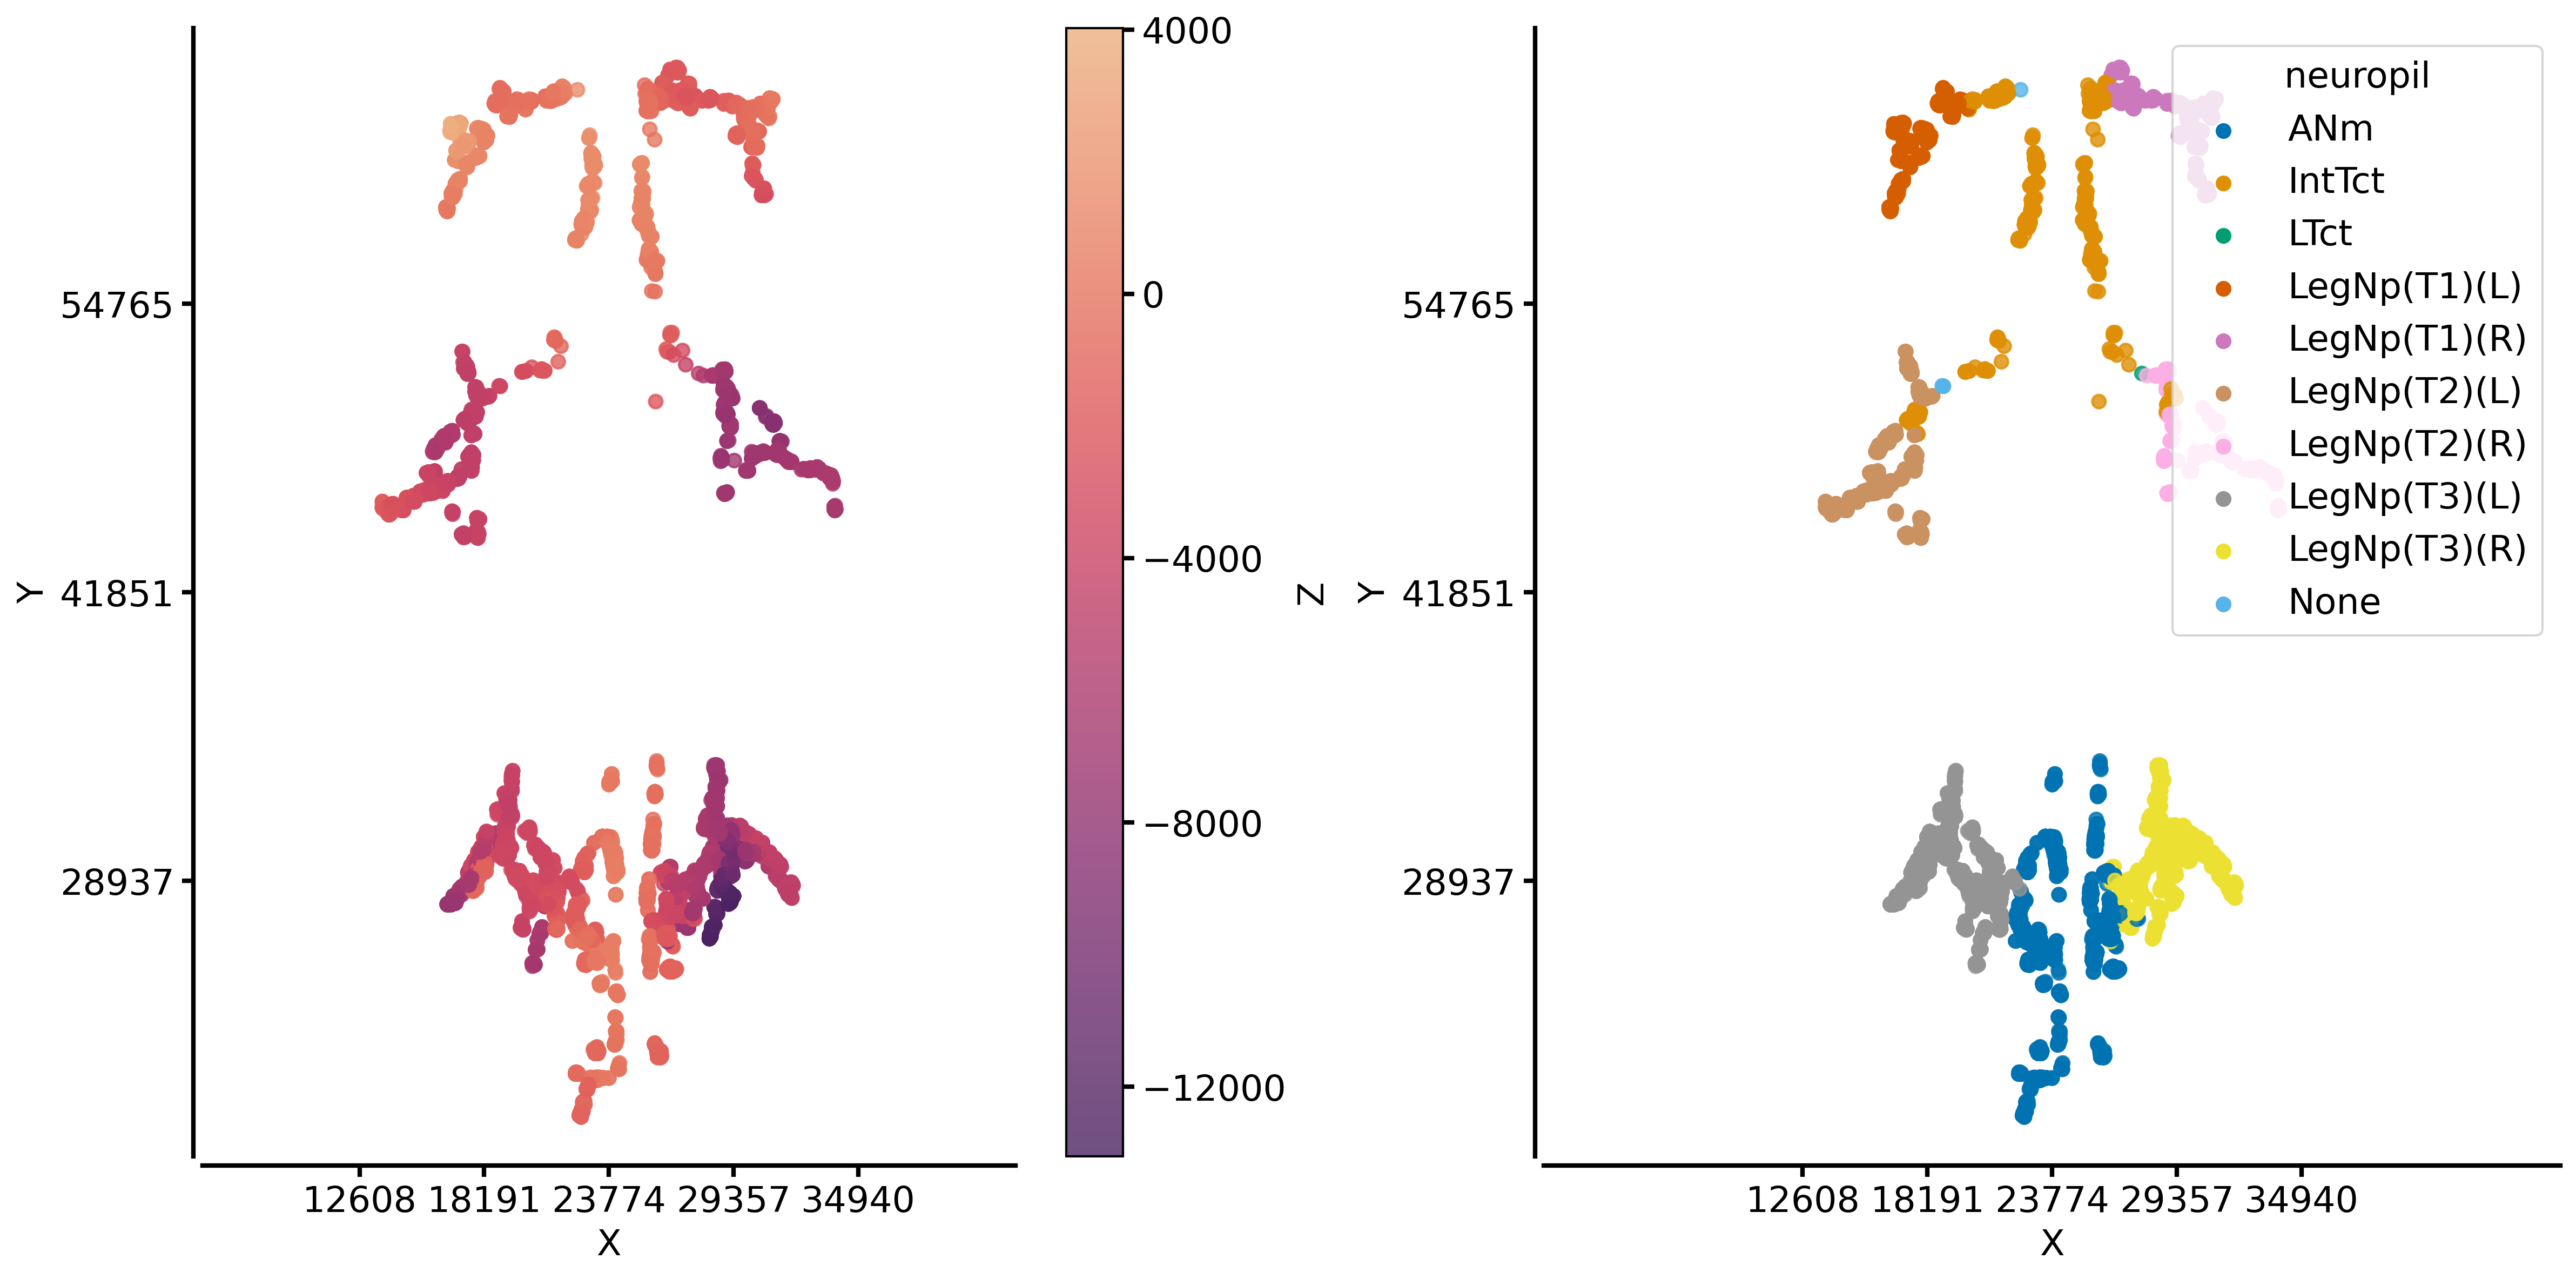

In [4]:
# Verify that the synapse distribution for the MDNs makes sense
mdn_bids = CR.get_neuron_bodyids({"type": "MDN"})
mdns = [
    Neuron(from_file=f'neuron-{bid}_neuropil-split', CR=CR)
    for bid in mdn_bids
]
# Figure: synapse distribution, left: depth coloured, right: neuropil colored
angle = -60 # angle of the neuropil display
X1, Y1, Z1 = [],[],[]
X2, Y2, Z2 = [],[],[]
for mdn in mdns:
    x1, y1, z1 = mdn.get_synapse_distribution(angle=angle)
    x2, y2, z2 = mdn.get_synapse_distribution(z_attribute="neuropil", angle=angle)
    X1.extend(x1)
    Y1.extend(y1)
    Z1.extend(z1)
    X2.extend(x2)
    Y2.extend(y2)
    Z2.extend(z2)

fig, axs = plt.subplots(
    1,
    2,
    figsize=(2*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
    )
plots_design.scatter_xyz_2d(
    X1, Y1, Z=Z1,
    ax=axs[0],
    cmap=params.r_red_colorscale
    )
axs[0].axis('equal')
plots_design.scatter_xyz_2d(
    X2,
    Y2,
    Z=Z2,
    z_label="neuropil",
    discrete_coloring=True,
    ax=axs[1],
    cmap=params.colorblind_palette,
)
axs[1].axis("equal")

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(
        MDN_FIGS, "MDN_synapse_distribution.pdf"
    ))
plt.show()

The subdivisions of the synapses by neuropils appears to be sensible.
We can now look at the connectivity resulting from each MDN set.

### 1Ab Connectivity between MDN sets and motor neurons

In [5]:
def confusion_matrix_mdn_to_mn(
        connections: Connections,
        n_hops: int = 2,
    ):
    """
    Create a confusion matrix of the number of connections from MDN to motor
    neurons within n hops, where the rows are the MDNs split by neuropil and
    the columns are the motor neurons split by leg.
    """
    legs = ["f", "m", "h"]
    sides = ["R", "L"]
    mdn_uids = [] # 3 x 2 list of lists
    for leg in legs:
        for side in sides:
            mdn_uids.append(
                mdn_helper.get_subdivided_mdns(
                    connections, neuropil=leg, side=side
                )
            )
        
    # Get the uids of motor neurons split by leg
    list_motor_neurons = []
    for leg in legs:
        for side in sides:
            leg_motor_neurons = list(
                mns_helper.get_leg_motor_neurons(connections, leg=leg, side=side)
            )
            list_motor_neurons.append(leg_motor_neurons)

    # Get the summed connection strength up to n hops
    eff_weight_abs = connections.get_cmatrix(type_="norm")
    eff_weight_abs.absolute()
    eff_weight_abs.within_power_n(n_hops)

    # Get the confusion matrix
    confusion_matrix = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            mat = copy.deepcopy(eff_weight_abs)
            mat.restrict_from_to(
                row_ids=mdn_uids[i],
                column_ids=list_motor_neurons[j],
                input_type="uid",
            )
            matrix = mat.get_matrix()
            confusion_matrix[i, j] = matrix.sum()

    return confusion_matrix

def plot_confusion_matrix_mdn_to_mn(
        confusion_matrix: np.ndarray,
        ax: Optional[plt.Axes] = None,
        side: Optional[str] = None,
    ):
    """
    Plot the confusion matrix of the number of connections from MDN to motor
    neurons within n hops, where the rows are the MDNs split by neuropil and
    the columns are the motor neurons split by leg.
    """
    if side is None: # bilateral plot
        # Plot the confusion matrix
        ax = matrix_design.imshow(
            confusion_matrix,
            ylabel="MDN subdivision",
            row_labels=["T1_R", "T1_L", "T2_R", "T2_L", "T3_R", "T3_L"],
            xlabel="leg motor neuron",
            col_labels=["f_R", "f_L", "m_R", "m_L", "h_R", "h_L"],
            title="Confusion matrix of MDN to MN connections",
            cmap=params.grey_heatmap,
            vmin=0,
            ax=ax,
        )
    else: # unilateral plot
        row_labels = ["T1", "T2", "T3"]
        col_labels = ["f", "m", "h"]
        if side == "L":
            mat = confusion_matrix[1::2, 1::2]
            title = "Confusion matrix of MDN to MN connections (left)"
        elif side == "R":
            mat = confusion_matrix[0::2, 0::2]
            title = "Confusion matrix of MDN to MN connections (right)"
        else:
            raise ValueError("side must be either 'L' or 'R'")
        # Plot the confusion matrix
        ax = matrix_design.imshow(
            mat,
            ylabel="MDN subdivision",
            row_labels=row_labels,
            xlabel="leg motor neuron",
            col_labels=col_labels,
            title=title,
            cmap=params.grey_heatmap,
            vmin=0,
            ax=ax,
        )
    return ax


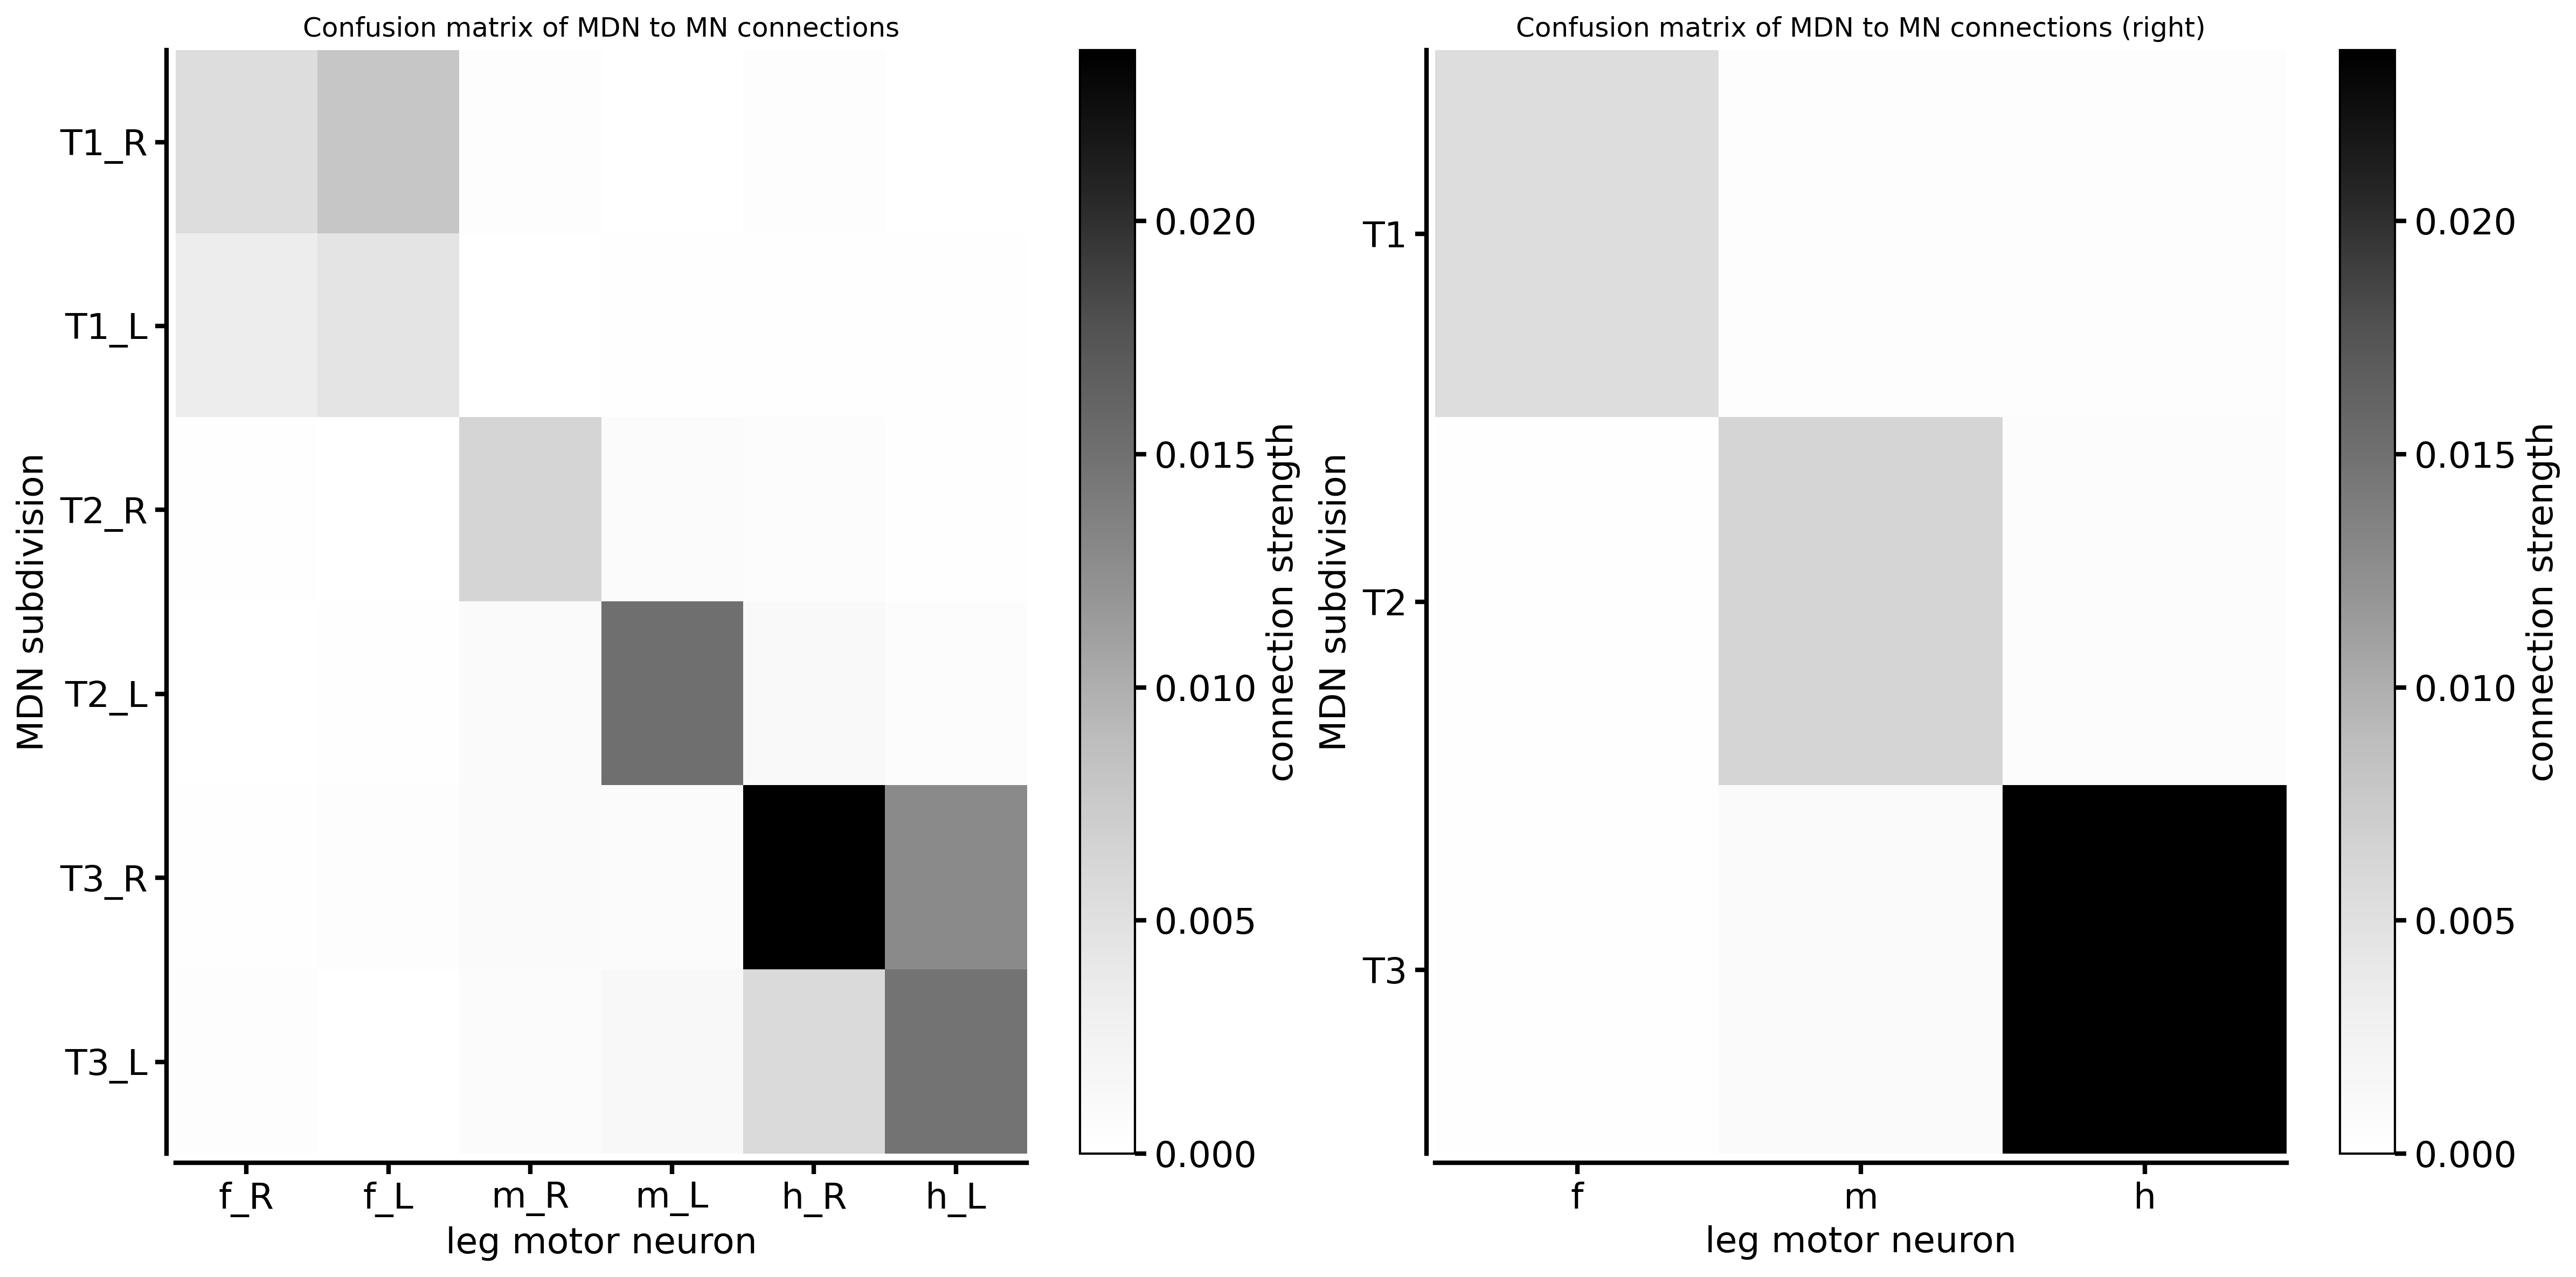

In [6]:
conf_mat = confusion_matrix_mdn_to_mn(
    connections=split_mdn_vnc,
    n_hops=2,
)
# Plotting
fig, axs = plt.subplots(
    1,
    2,
    figsize=(2*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
)
axs[0] = plot_confusion_matrix_mdn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[0],
)
axs[1] = plot_confusion_matrix_mdn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[1],
    side="R",
)
if savefigs:
    plt.savefig(os.path.join(
        MDN_FIGS, "MDN_to_MN_confusion_matrix.pdf"
    ))
plt.show()


The main component is diagonal, meaning that the MDN sets connect to motor neurons in the same leg neuropil. There seems to be cross talk to the contralateral side, but it is much weaker, and mostly true for the front legs, not as much for the hind legs.
There is also a strong difference on both sides for a given leg, which can be due to tracing incompleteness. 
Given that we are mostly interested in the hind legs, we will focus on the right side that has a better reconstruction.

As a safety check, we want to make sure that this result is not an artefact created by the restiction to 2 hops connections. Since the network has been described as small-world, we want verify that our conclusions hold within 4 hops.

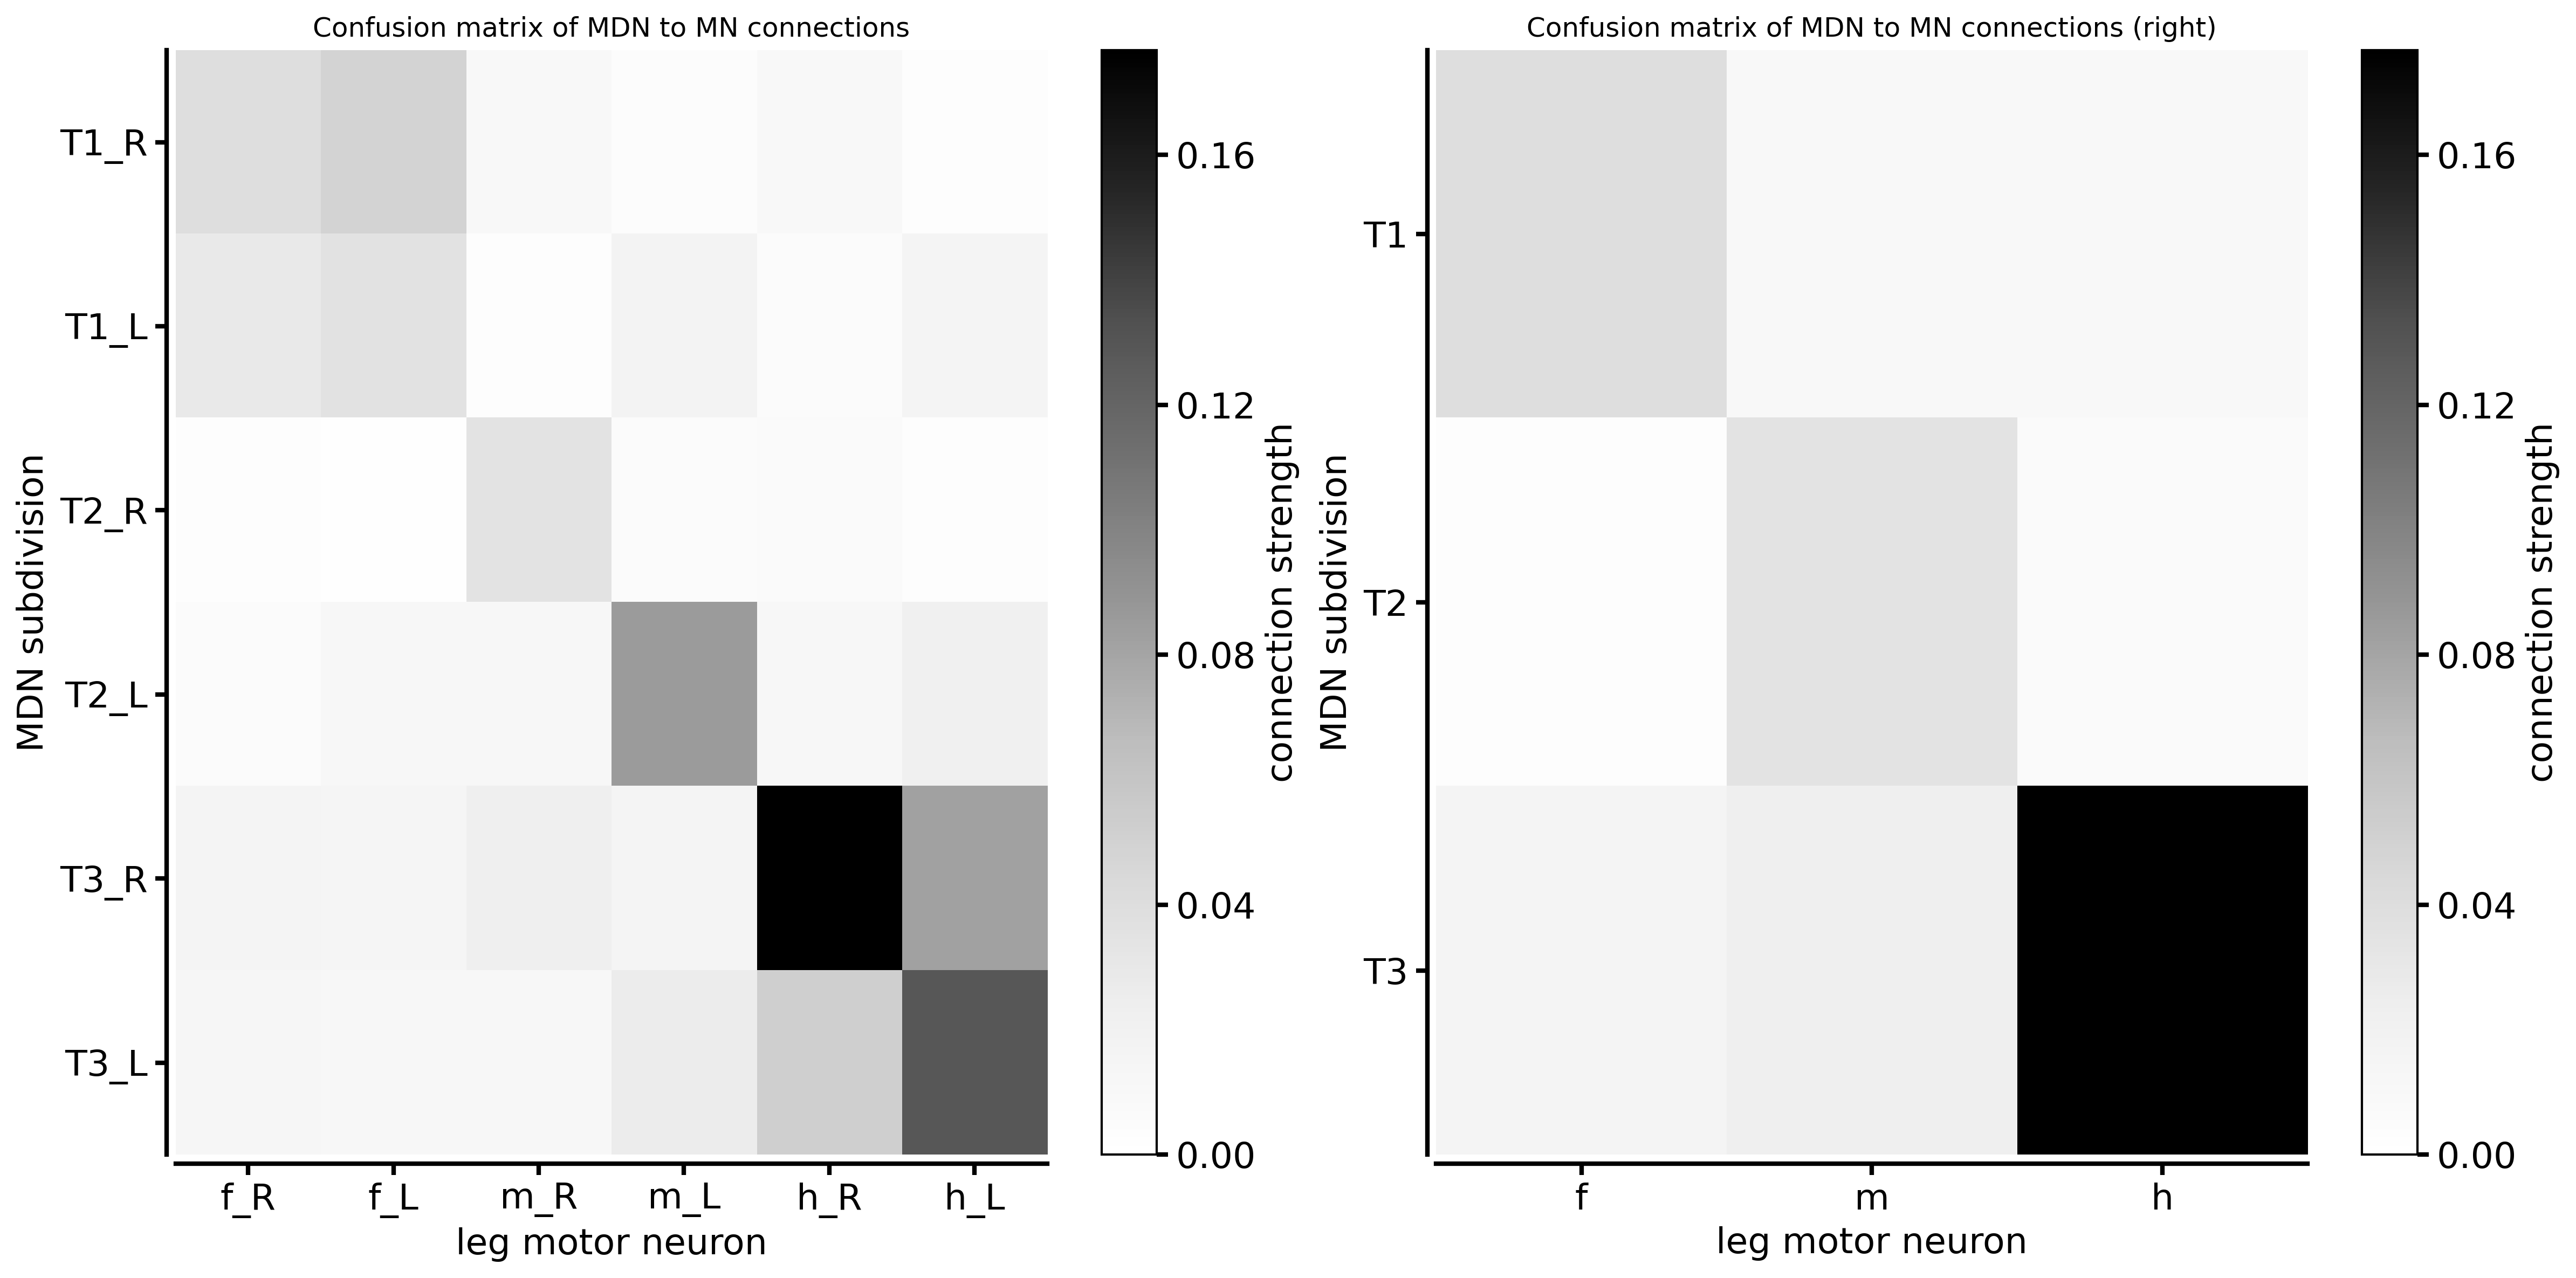

In [7]:
conf_mat = confusion_matrix_mdn_to_mn(
    connections=split_mdn_vnc,
    n_hops=4,
)
# Plotting
fig, axs = plt.subplots(
    1, 2, figsize=(2 * params.FIG_WIDTH, params.FIG_HEIGHT), dpi=params.DPI
)
axs[0] = plot_confusion_matrix_mdn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[0],
)
axs[1] = plot_confusion_matrix_mdn_to_mn(
    confusion_matrix=conf_mat,
    ax=axs[1],
    side="R",
)
if savefigs:
    plt.savefig(os.path.join(MDN_FIGS, "MDN_to_MN_confusion_matrix_4_hops.pdf"))
plt.show()


The diagonal components are still the strongest. We will focus on 2-hops connections in most of the following analysis.

# Part 1B: Movement space of MDN sets

We dive further in the details of how many and which motor neurons are recruited by MDNs in each leg neuropil. All the analysis will be done on the right side, which has a better reconstruction at least for the hind legs.

In [9]:
# List of all the muscles that can targeted 
Unclear = [  
    "Tergopleural/Pleural promotor",
    "Pleural remotor/abductor",
    "Sternal anterior rotator",
    "Sternal posterior rotator",
    "Sternal adductor",
    "Fe reductor",
    "ltm",
    "ltm2-femur",
    "ltm1-tibia",
]
Extensors = [
    "Tergotr.",
    "Sternotrochanter",
    "Tr extensor",
    "Ti extensor",
    "Ta depressor",
]
Flexors = [
    "Tr flexor"
    "Acc. tr flexor",
    "Ti flexor",
    "Acc. ti flexor",
    "Ta levator",
]
Muscles = Unclear + Extensors + Flexors


In [10]:
def average_weight_from_mdn_to_muscle(
        leg: str,
        side: str,
        muscle: str,
        connections: Connections,
        cmat: CMatrix,
    ):
    """
    Get the average connection strength from MDN to a muscle, uising the weights
    from the connection matrix.
    """
    source = mdn_helper.get_subdivided_mdns(connections, neuropil=leg, side=side)
    target = connections.get_neuron_ids(
        {
            "class_1": "motor",
            "class_2": leg,
            "target": muscle,
            "side": side,
        }
    )
    if len(target) == 0:
        return np.nan
    # Restrict the connection matrix to its relevant entries
    mat = copy.deepcopy(cmat)
    mat.restrict_from_to(
        row_ids=source,
        column_ids=target,
        input_type="uid",
    )
    matrix = mat.get_matrix()
    return matrix.mean()

In [11]:
# compute the effective connection weights for any pair of neurons
cmat_pos = split_mdn_vnc.get_cmatrix(type_="norm")
cmat_neg = copy.deepcopy(cmat_pos)

cmat_pos.square_positive_paths_only() # effective excitatory connections length 2
cmat_neg.square_negative_paths_only()

In [12]:
positive_weights = np.zeros((3, len(Muscles)))

for i, neuropil in enumerate(["fl", "ml", "hl"]):
    for j, muscle in enumerate(Muscles):
        positive_weights[i, j] = average_weight_from_mdn_to_muscle(
            leg=neuropil,
            side="RHS",
            muscle=muscle,
            connections=split_mdn_vnc,
            cmat=cmat_pos,
        )

negative_weights = np.zeros((3, len(Muscles)))
for i, neuropil in enumerate(["fl", "ml", "hl"]):
    for j, muscle in enumerate(Muscles):
        negative_weights[i, j] = average_weight_from_mdn_to_muscle(
            leg=neuropil,
            side="RHS",
            muscle=muscle,
            connections=split_mdn_vnc,
            cmat=cmat_neg,
        )                 

In [13]:
max_scale = max(np.nanmax(positive_weights), abs(np.nanmin(negative_weights)))

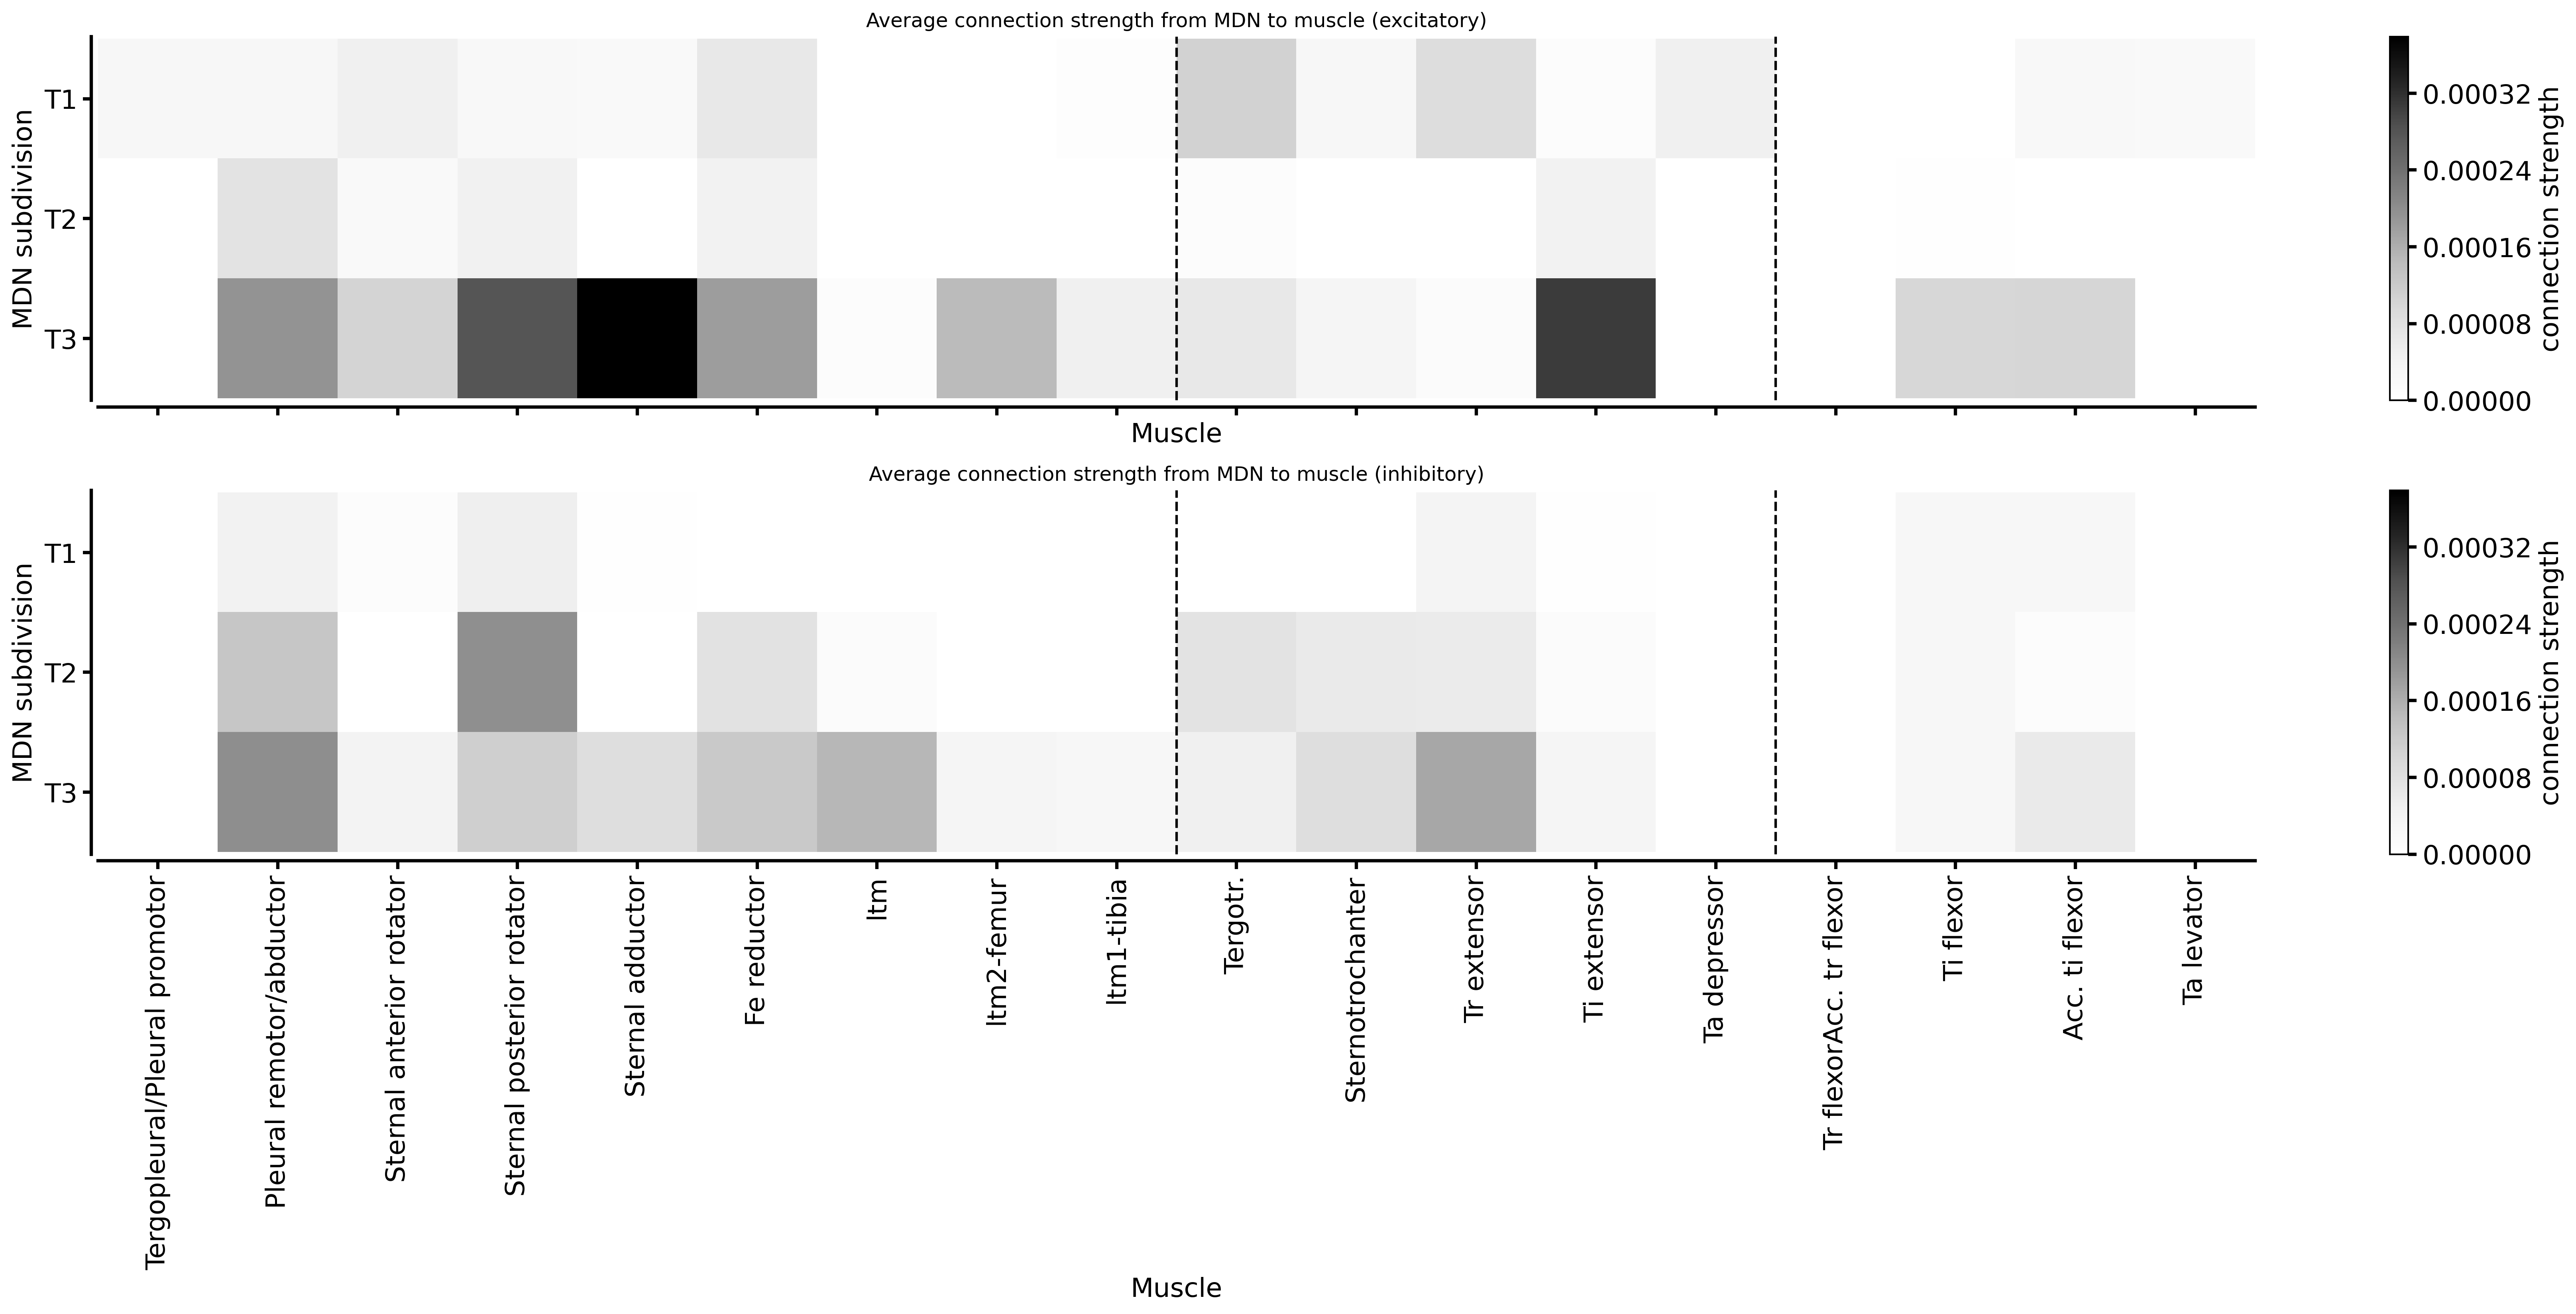

In [14]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(3*params.FIG_WIDTH, params.FIG_HEIGHT),
    dpi=params.DPI
)
vertical_marks = [len(Unclear) - 0.5, len(Extensors) + len(Unclear) - 0.5]

axs[0] = matrix_design.imshow(
    positive_weights,
    ylabel="MDN subdivision",
    row_labels=["T1", "T2", "T3"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="Average connection strength from MDN to muscle (excitatory)",
    cmap=params.grey_heatmap,
    vmin=0,
    vmax=max_scale,
    ax=axs[0],
)
# remove x ticks
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1] = matrix_design.imshow(
    -1 * negative_weights,
    ylabel="MDN subdivision",
    row_labels=["T1", "T2", "T3"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="Average connection strength from MDN to muscle (inhibitory)",
    cmap=params.grey_heatmap,
    vmax=max_scale,
    vmin=0,
    ax=axs[1],
)

# set axis equal
for ax in axs:
    ax.axis("equal")

for mark in vertical_marks:
    axs[0].axvline(mark, color="k", linestyle="--")
    axs[1].axvline(mark, color="k", linestyle="--")

plt.tight_layout()
plt.xticks(rotation=90)

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "MDN_to_muscle_connection_strength.pdf"),
        bbox_inches="tight", # don't crop the legend
    )

plt.show()

The effective conenction strength from the MDN sets to the motor neurons is very different between the front, middle and hind legs. The hind legs have a much stronger connection, which is consistent with the fact that they are the main legs used for backwards walking.

For the front leg, the strongest innervation is going to the leg extensors, esp. the tibia extensor.

For the middle leg, there appears to be mostly inhibition of the motor neurons.

For the hind legs, there is both excitation and inhibition fo ra given muscle, suggesting that the patterning will matter more. The coxa is the most strongly innervated joint.

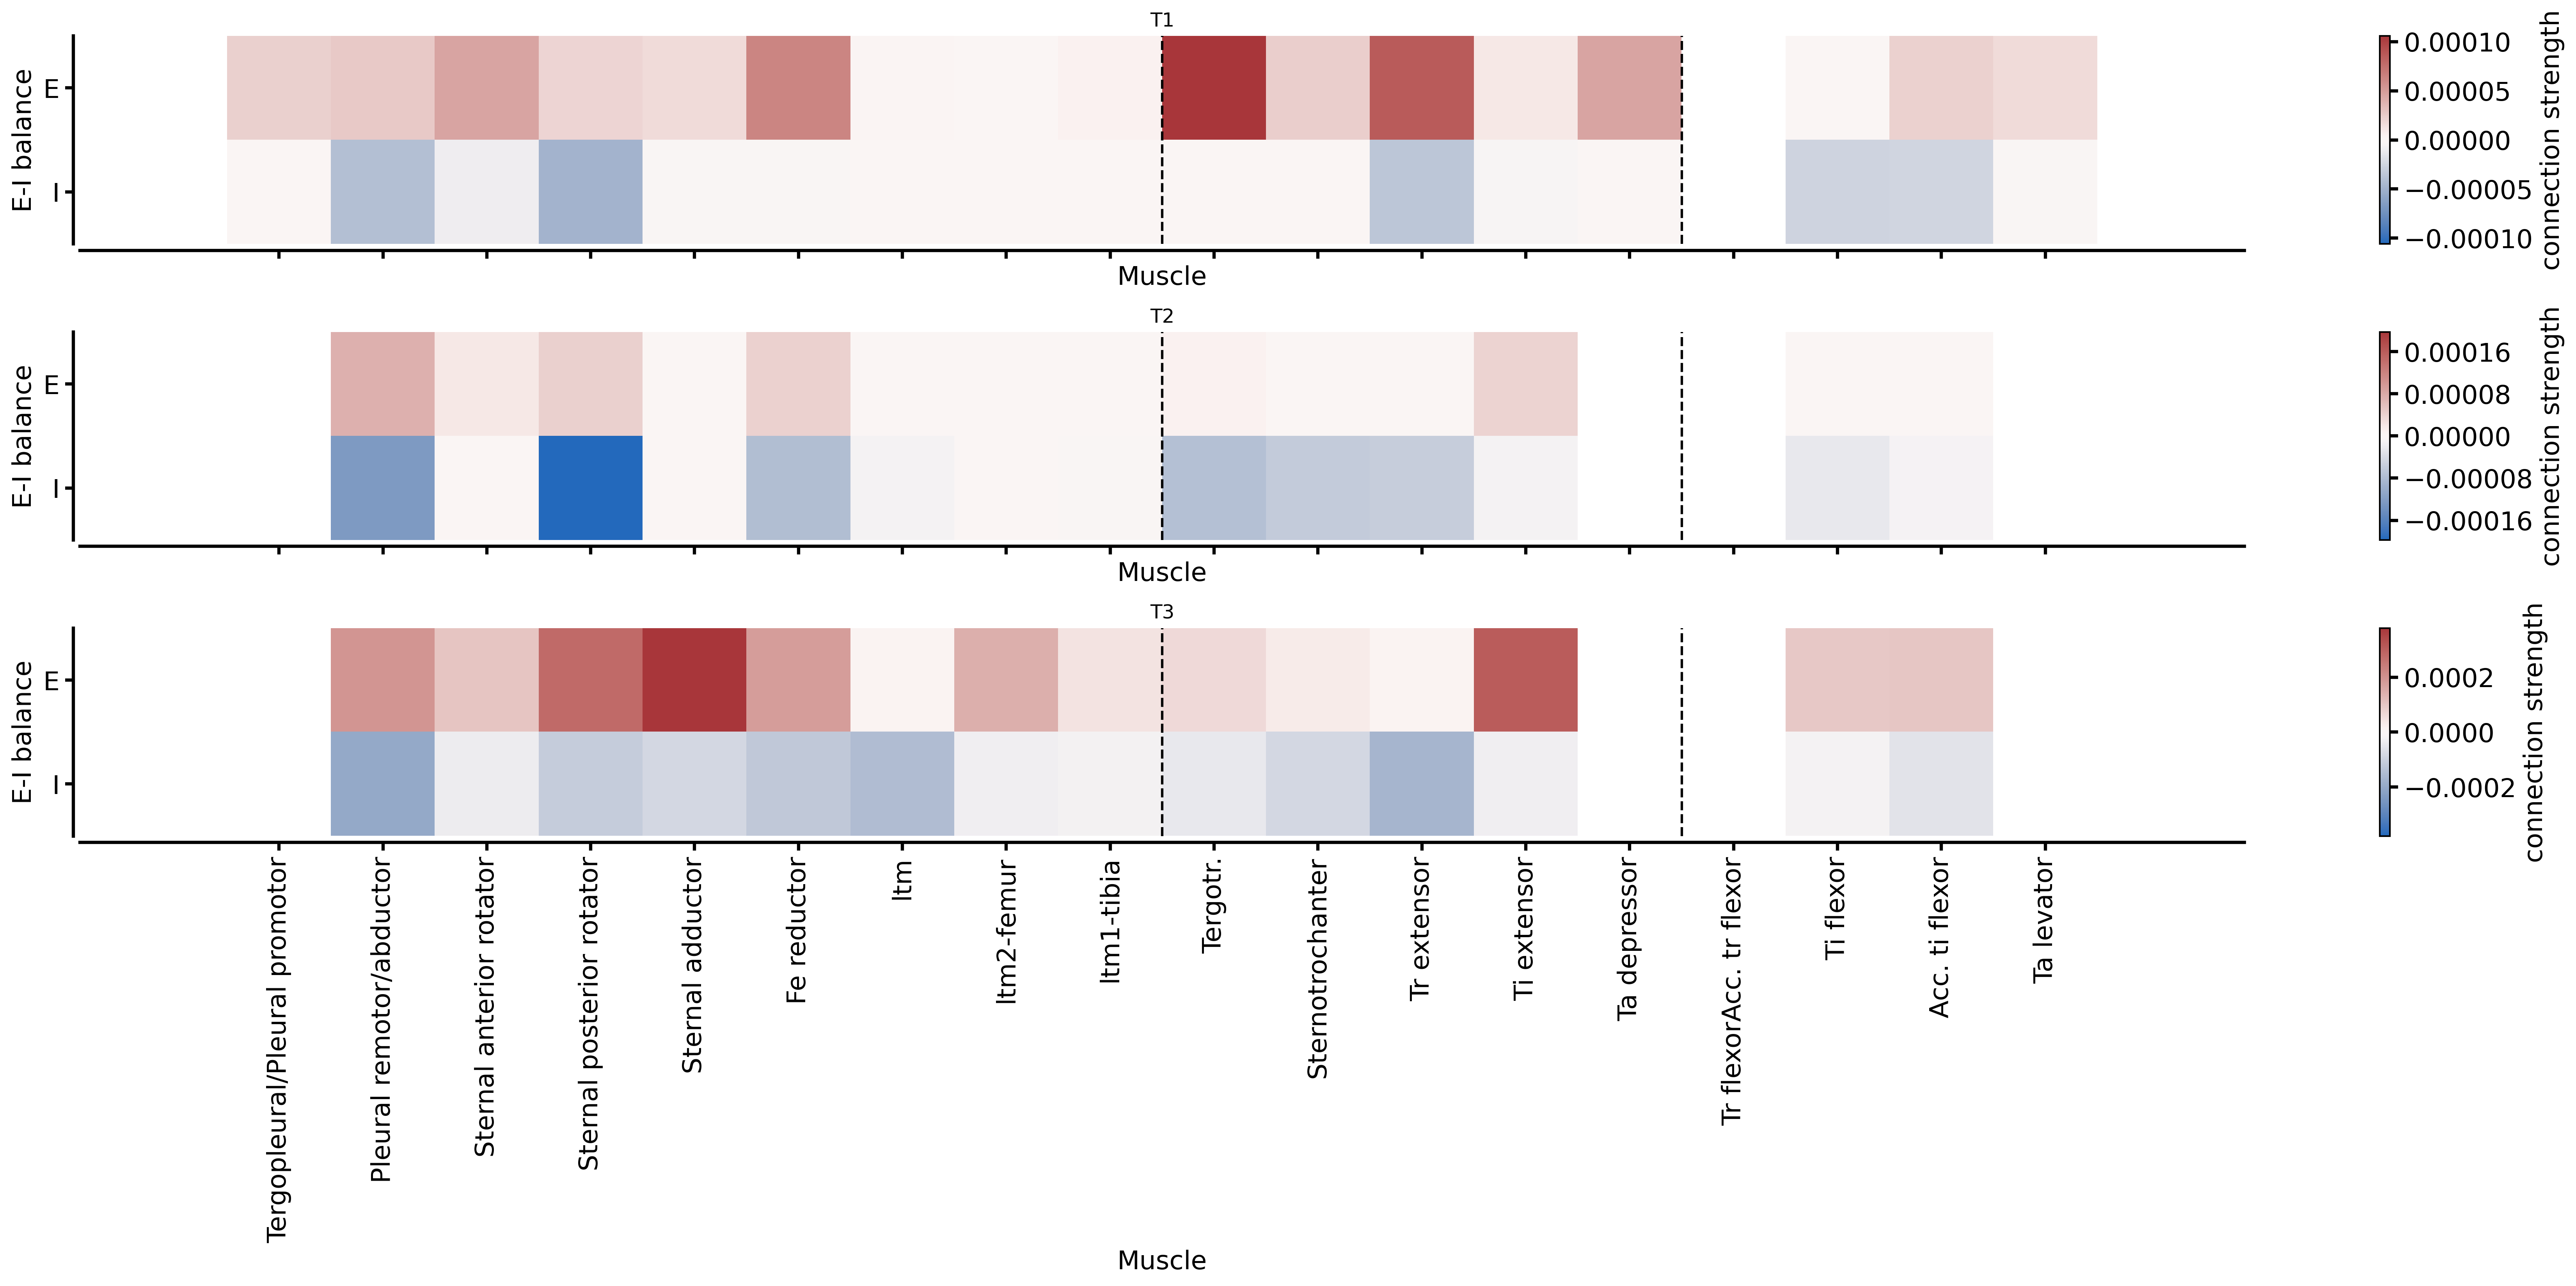

In [15]:
# Highlight the differences in excitation and inhibition for a given neuropil
fig, axs = plt.subplots(
    3, 1, figsize=(3 * params.FIG_WIDTH, params.FIG_HEIGHT), dpi=params.DPI
)
vertical_marks = [len(Unclear) - 0.5, len(Extensors) + len(Unclear) - 0.5]

T1 = [positive_weights[0], negative_weights[0]]
T2 = [positive_weights[1], negative_weights[1]]
T3 = [positive_weights[2], negative_weights[2]]

axs[0] = matrix_design.imshow(
    T1,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T1",
    cmap=params.diverging_heatmap,
    ax=axs[0],
)
# remove x ticks
plt.setp(axs[0].get_xticklabels(), visible=False)

axs[1] = matrix_design.imshow(
    T2,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T2",
    cmap=params.diverging_heatmap,
    ax=axs[1],
)
# remove x ticks
plt.setp(axs[1].get_xticklabels(), visible=False)

axs[2] = matrix_design.imshow(
    T3,
    ylabel="E-I balance",
    row_labels=["E", "I"],
    xlabel="Muscle",
    col_labels=Muscles,
    title="T3",
    cmap=params.diverging_heatmap,
    ax=axs[2],
)

# set axis equal
for ax in axs:
    ax.axis("equal")

for mark in vertical_marks:
    axs[0].axvline(mark, color="k", linestyle="--")
    axs[1].axvline(mark, color="k", linestyle="--")
    axs[2].axvline(mark, color="k", linestyle="--")

plt.tight_layout()
plt.xticks(rotation=90)

if savefigs:
    plt.savefig(
        os.path.join(MDN_FIGS, "MDN_to_muscle_connection_strength_per_leg.pdf"),
        bbox_inches="tight", # don't crop the legend
        )

plt.show()